In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.chdir(r'C:\Users\itwill\Desktop')
print(os.getcwd())

C:\Users\itwill\Desktop


In [3]:
import pandas as pd
data_taka=pd.read_csv('taka_remove.csv')

In [4]:
import re
import emoji

def clean_text(text):
    # 이모지 제거
    text = emoji.replace_emoji(text, replace='')

    # 줄바꿈 → 공백
    text = re.sub(r'\n', ' ', text)

    # 숫자 포함
    text = re.sub(r'\S*\d\S*', '', text)

    # 한자 제거
    text = re.sub(r'#\S*[\u4E00-\u9FFF]\S*', '', text)

    # 일본어 거거
    text = re.sub(r'#\S*[\u3040-\u309F\u30A0-\u30FF]\S*', '', text)

    # 한자/일본어 제거
    text = re.sub(r'[\u4E00-\u9FFF\u3040-\u309F\u30A0-\u30FF]', '', text)

    # 특수문자 제거 
    text = re.sub(r'[^\w\s#]', '', text)

    # 여러 공백을 하나로, 양쪽 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()

    return text


data_taka['caption_clean'] = data_taka['caption'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')


In [5]:
data_taka.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            246 non-null    object 
 1   caption        246 non-null    object 
 2   hashtags       213 non-null    object 
 3   likes          240 non-null    float64
 4   image_url      246 non-null    object 
 5   caption_clean  246 non-null    object 
dtypes: float64(1), object(5)
memory usage: 11.7+ KB


In [6]:
import pandas as pd
data_tongyeong=pd.read_csv('tongyeong.csv')

In [7]:
import re
import emoji

def clean_text(text):
    # 이모지 제거
    text = emoji.replace_emoji(text, replace='')

    # 줄바꿈 → 공백
    text = re.sub(r'\n', ' ', text)

    # 숫자 포함
    text = re.sub(r'\S*\d\S*', '', text)

    # 한자 제거
    text = re.sub(r'#\S*[\u4E00-\u9FFF]\S*', '', text)

    # 일본어 거거
    text = re.sub(r'#\S*[\u3040-\u309F\u30A0-\u30FF]\S*', '', text)

    # 한자/일본어 제거
    text = re.sub(r'[\u4E00-\u9FFF\u3040-\u309F\u30A0-\u30FF]', '', text)

    # 특수문자 제거 
    text = re.sub(r'[^\w\s#]', '', text)

    # 여러 공백을 하나로, 양쪽 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()

    return text


data_tongyeong['caption_clean'] = data_tongyeong['caption'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')


In [8]:
###################################################    KoBERT     #####################################################

In [9]:
from kobert_transformers import get_tokenizer
from transformers import BertModel

model = BertModel.from_pretrained("monologg/kobert")
tokenizer = get_tokenizer()

# 문장
sentence = "안녕하세요, KoBERT 테스트 중입니다."

# 4. 토큰화 출력
tokens = tokenizer.tokenize(sentence)
print("Tokens:", tokens)

# 5. 토큰을 모델 입력 형태로 변환
inputs = tokenizer(sentence, return_tensors="pt")

# 6. 모델에 입력 후 출력 받기
outputs = model(**inputs)

print("Last Hidden State shape:", outputs.last_hidden_state.shape)
print("Pooler Output shape:", outputs.pooler_output.shape)


Tokens: ['▁안', '녕', '하세요', ',', '▁K', 'o', 'B', 'ER', 'T', '▁테스트', '▁중', '입니다', '.']
Last Hidden State shape: torch.Size([1, 15, 768])
Pooler Output shape: torch.Size([1, 768])


In [10]:
from kobert_transformers import get_tokenizer
from transformers import BertModel

model = BertModel.from_pretrained("skt/kobert-base-v1")
tokenizer = get_tokenizer()

# 문장
sentence = "안녕하세요, KoBERT 테스트 중입니다."

# 4. 토큰화 출력
tokens = tokenizer.tokenize(sentence)
print("Tokens:", tokens)

# 5. 토큰을 모델 입력 형태로 변환
inputs = tokenizer(sentence, return_tensors="pt")

# 6. 모델에 입력 후 출력 받기
outputs = model(**inputs)

print("Last Hidden State shape:", outputs.last_hidden_state.shape)
print("Pooler Output shape:", outputs.pooler_output.shape)

# last_hidden_state : 문장 내 각 토큰의 문맥적 의미 임베딩
# pooler_output : 문장 전체를 대표하는 임베딩 벡터, [cLS]토큰



Tokens: ['▁안', '녕', '하세요', ',', '▁K', 'o', 'B', 'ER', 'T', '▁테스트', '▁중', '입니다', '.']
Last Hidden State shape: torch.Size([1, 15, 768])
Pooler Output shape: torch.Size([1, 768])


In [11]:
############kobert 사용해서 토큰화가 어떻게 수행되었는지 보기

In [12]:
tokenized_texts = [tokenizer.tokenize(sentence) for sentence in data_taka['caption_clean']]
data_taka["tokens"] = data_taka['caption_clean'].apply(lambda x: tokenizer.tokenize(x))
data_taka.to_csv("taka_tokenized_check_and_remove.csv", index=False, encoding="utf-8-sig")
data_taka.drop(columns=["tokens"], inplace=True)

In [14]:
##############      BERT 예시       ##############

import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# 문장을 임베딩으로 변환하는 함수
def get_embedding(text):
    # 텍스트를 토큰화
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    
    # 모델을 통해 임베딩 계산
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 임베딩은 마지막 hidden state를 사용
    embeddings = outputs.last_hidden_state.mean(dim=1)  # 평균으로 문서 임베딩을 구함
    
    return embeddings

# 두 문서 예시
doc1 = "오늘 날씨가 너무 좋다."
doc2 = "오늘은 날씨가 맑고 기분이 좋다."

# 각 문서의 임베딩을 구함
embedding1 = get_embedding(doc1)
embedding2 = get_embedding(doc2)

# 코사인 유사도 계산
cos_sim = cosine_similarity(embedding1.numpy(), embedding2.numpy())
print(f"Cosine similarity between the two documents: {cos_sim[0][0]}")


Cosine similarity between the two documents: 0.7597843408584595


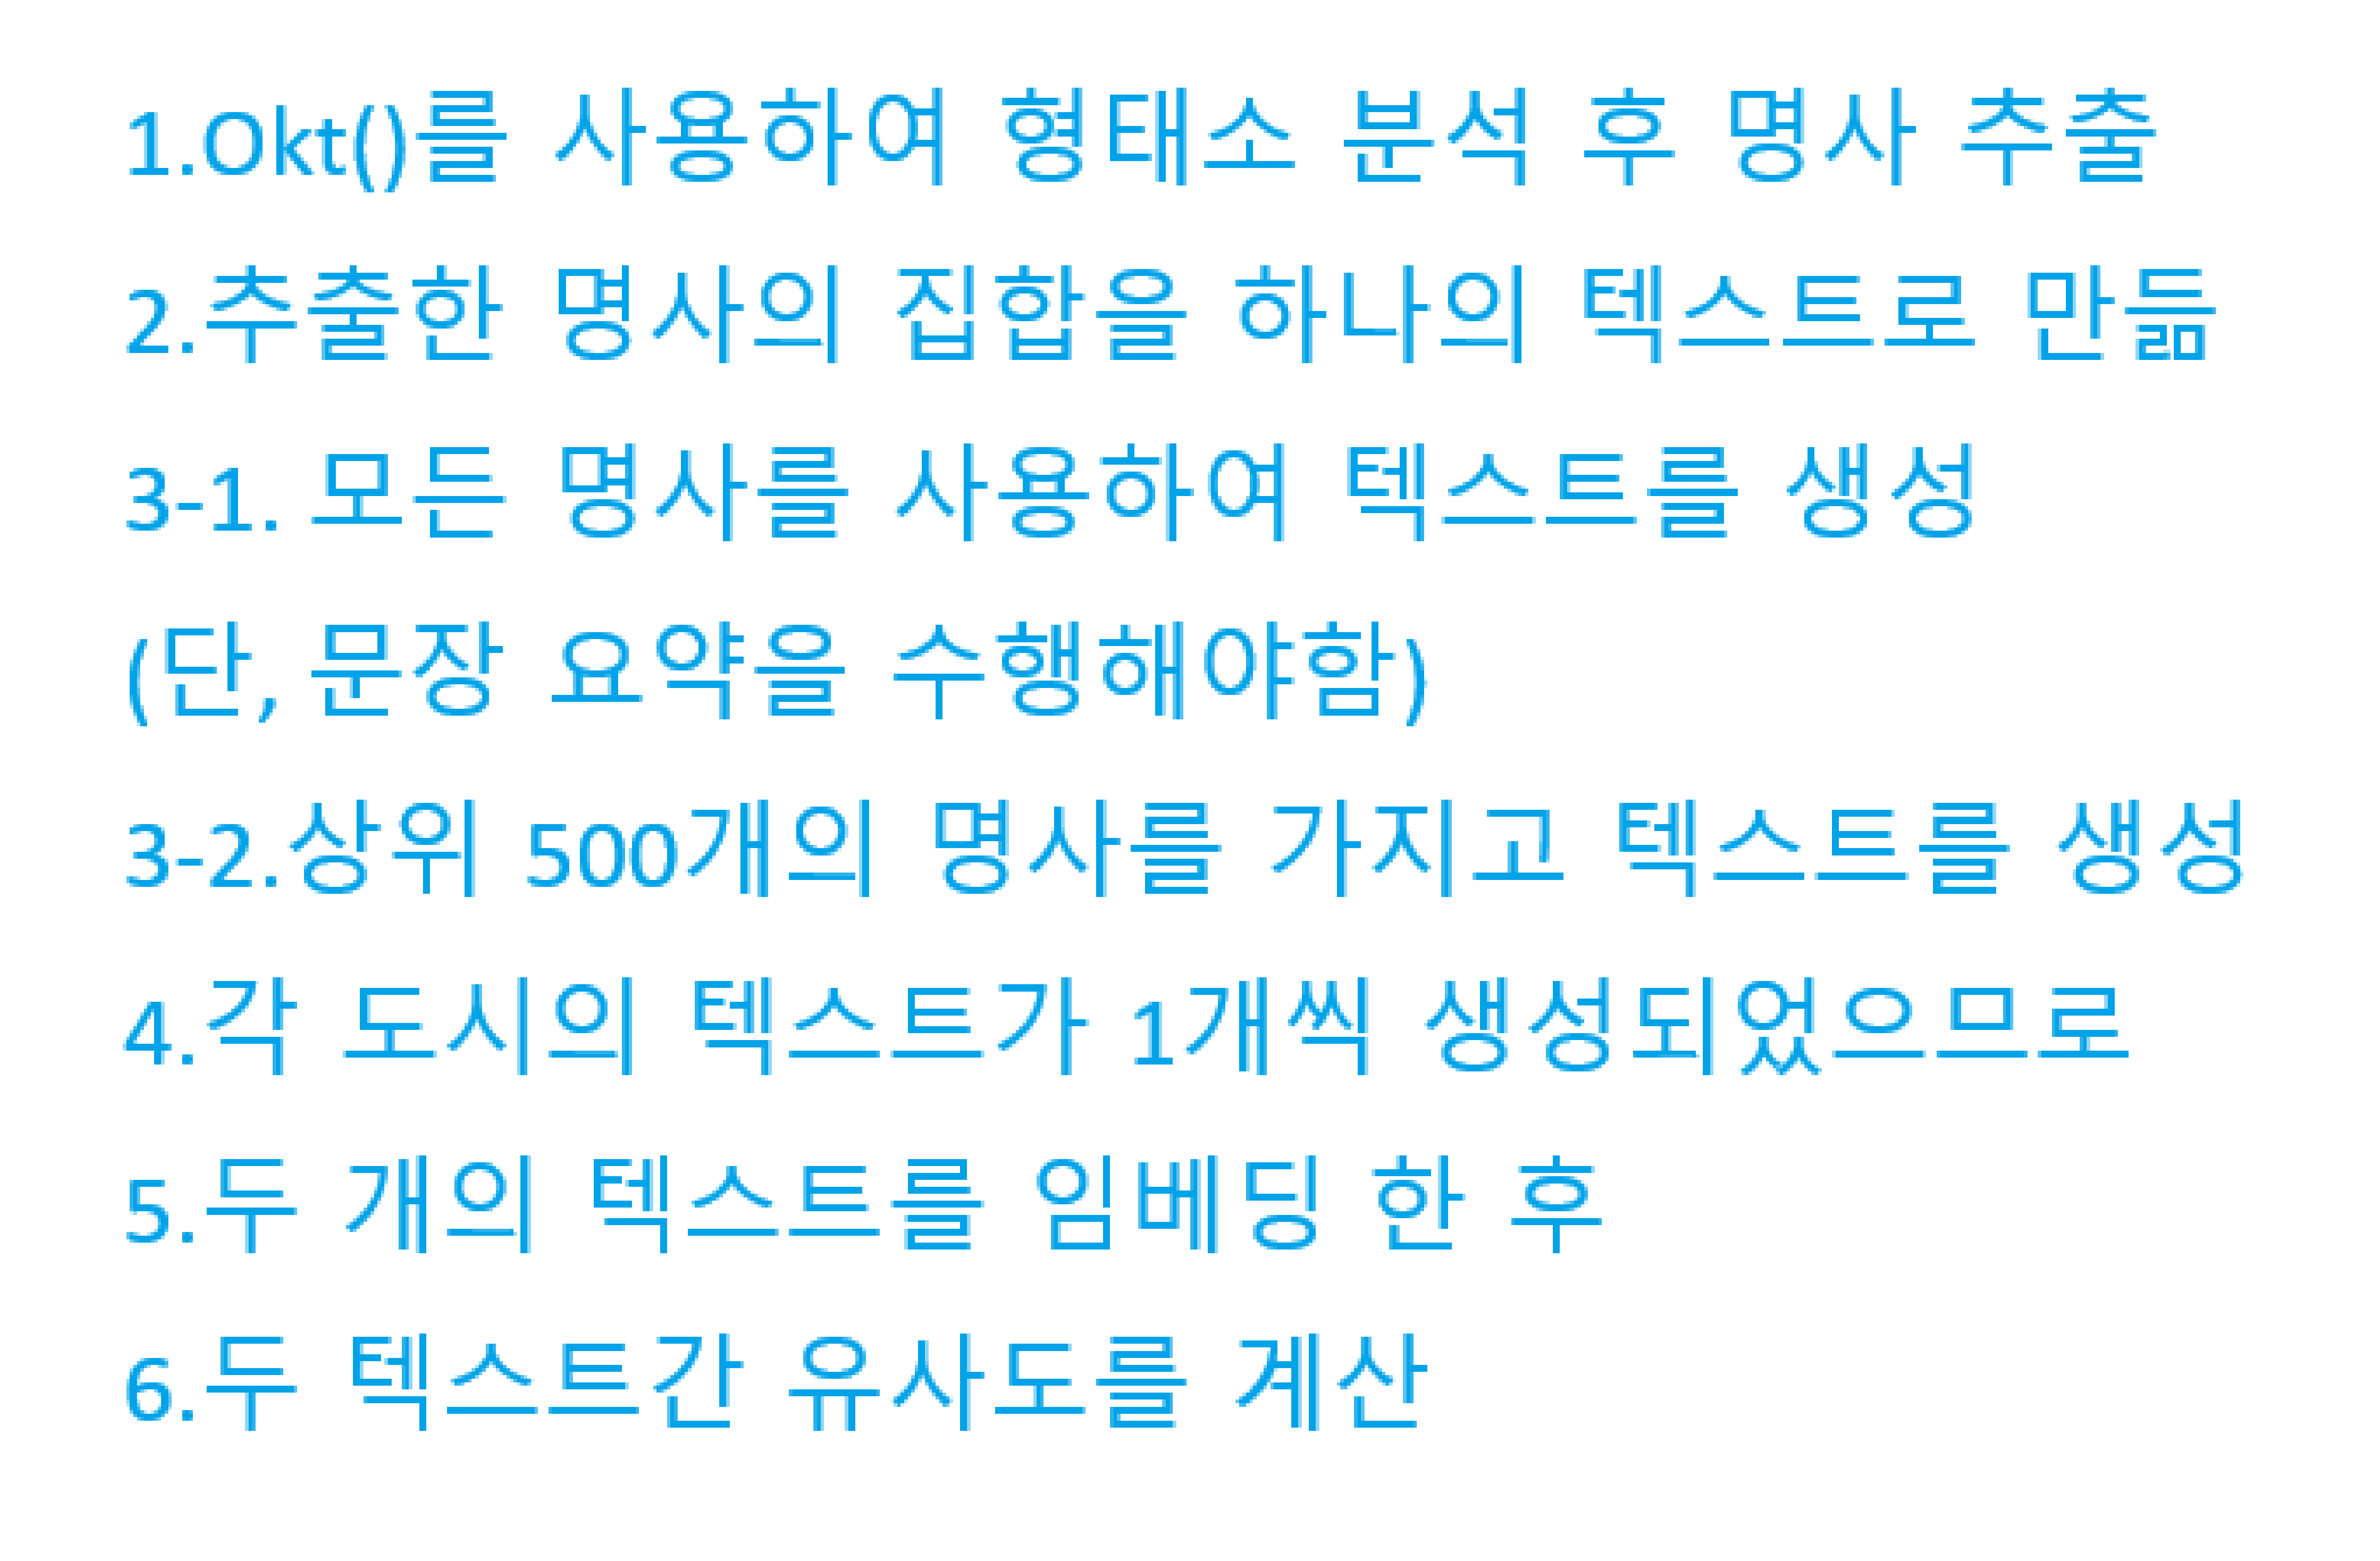

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 경로 설정
img = mpimg.imread(r'C:\Users\itwill\Desktop\okt.png')

# 이미지를 화면에 표시
plt.figure(dpi=1000)
plt.imshow(img)
plt.axis('off')  
plt.show()

In [16]:
from konlpy.tag import Okt
okt=Okt()
def extract_nouns(text):
    # Okt를 사용해 명사만 추출
    nouns = okt.nouns(text)
    # 한 단어로 이루어진 명사는 삭제
    filtered_nouns = [noun for noun in nouns if len(noun) > 1]
    return ' '.join(filtered_nouns)


data_taka['caption_nouns'] = data_taka['caption_clean'].apply(extract_nouns)
result_taka = ' '.join(data_taka['caption_nouns'])

data_tongyeong['caption_nouns'] = data_tongyeong['caption_clean'].apply(extract_nouns)
result_tongyeong= ' '.join(data_tongyeong['caption_nouns'])


In [17]:
print(result_taka) #모든 명사를 추출함

디토 지금 일본 다카마쓰 여행 도시 행복 저장 공유 필수 다카마쓰 인생 우동 그릇 뚝딱 가면 무조건 맛집 힐링 관광 스팟 정리 이제 뱅기 티켓 숙소 예약 바로 다카마쓰 준비 완료 매장 주소 댓글 확인 일본 다카마쓰 우동 투어 나미 당일치기 우동 투어 하시모토 면소 젓가락 그릇 필요 기대 아빠 그냥 생각 나무 젓가락 거기 몇개 간장 아주 조금 비비고 넣기 마쓰 치킨 카레 우동 카시 덴푸라 가루 고추기름 비비 진짜 아빠 먹음 나미 보고 주문 잘못 카시 튀김 세이 우동 레스토랑 우동 우동 소스 생강 넣기 얼음 만큼 우동 와사비 추천 우동 생강 한국말 외국인 직원 소통 튀김 가루 식감 튀김 가루 모리 우동 튀김 우동 미니 기사 추천 모리 우동 분위기 삼삼오오 사람 체인점 미니 우동 요기 간다 추천 미니 여성 튀김 바싹 국물 조금 자극 공항 진짜 여기 강추 셀프 우동 노부 마감 미리 미리 택시 합의 보시 나미 공항 미리 협의 추천 가격 거나 고정 회사 연락 이야기 기사 얼마나 전혀 문제 시간 처음 택시 정도 타고 택시 정도 계산 당일치기 시간 싸움 시간 협의 정말 택시 보이지 잡기 가게 택시 불러쥬셔 바로 가게 택시 달라 동선 조금 가뜩이나 직원 실례 기사 지름길 가시 역시 택시 폭탄 각오 일본 다카마쓰 붓쇼잔 온천 노천 실내 냉탕 구분 샴푸 바디 워시 용품 비치 비누 로션 중고 서적 판매 내부 식당 힐링 시간 사진 부채 붓쇼잔 패스 다카마쓰 칫코역 역무 구매 당일 기준 다카마쓰 칫코역 붓쇼잔역 무제한 탑승 온천 입장료 포함 구매 토토 야돈 우동 고토덴 버스 다카마쓰 여행 처음 단둘 여행 컨디션 별로 불구 순간 여행 무엇 계단 절대 예전 여행 마음 일본 소도시 여행 세토대교 고토 공원 이야기 블로그 보물섬 투어 다카 마츠 자연 힐링 우동 예술 다카 마츠 여행 패키지 오이 토핑 소프트 아이스크림 제공 일본 전통 온천 보물섬 투어 힐링 다카 마츠 여행 내용 홈페이지 확인 다카마쓰 우동 당일치기 최소 이유 강남 다카마쓰 우동 당일치기 우동 정보 쌈뽕 당일치기 가능 진에어 일

In [18]:
len(set(result_taka.split())) # 다카마쓰에는 2400개의 단어가 존재

2406

In [19]:
len(set(result_tongyeong.split())) # 통영에는 3000개의 단어가 존재

3022

In [20]:
from collections import Counter
counter_taka = Counter(result_taka.split())
counter_tongyeong = Counter(result_tongyeong.split())

top_taka = [word for word, _ in counter_taka.most_common(500)]
top_tongyeong = [word for word, _ in counter_tongyeong.most_common(500)]


taka = ' '.join(top_taka)
tongyeong= ' '.join(top_tongyeong)


print(taka) #상위 500개만 뽑은 것
print('##########################')
print(tongyeong) #상위 500개만 뽑은 것


우동 다카마쓰 여행 일본 공원 시간 다카 소도시 야돈 사진 마츠 투어 예약 시코쿠 호텔 추천 예술 도시 미술관 맛집 온천 진짜 하나 숙소 버스 방문 생각 튀김 카페 사람 정말 가장 마루 도시마 공항 이번 정원 하루 힐링 카가와현 마치 자전거 작품 우리 바로 여기 가게 포함 사누키 올리브 다시 타고 역시 가능 감성 도착 쇼핑 호박 지역 정도 고토 자연 페리 최고 바다 일정 고장 슬라이드 그냥 보고 국물 패스 입장료 정보 이상 시작 항공권 아침 혼자 순례 카레 전통 가마 위치 매력 왕복 다음 코스 한국 아트 필수 그릇 분위기 처음 서울 타마 메뉴 링크 음식 거리 무료 가득 리츠 모두 오늘 다카마츠 시마 인생 면소 택시 가격 아이스크림 에어 운영 카가와 라멘 이자카야 친구 어디 전망대 사실 바람 편의점 카마 오픈 가가와현 무조건 관광 마음 영업 근처 가성 때문 이용 느낌 비행기 오뎅 먹기 명물 지금 조금 모리 내부 오후 경험 면발 버터 저녁 풍경 여유 동네 시내 기념품 츠키 계획 일본여행 신사 료칸 산책 후쿠오카 프렌즈 이제 당일치기 주문 미리 기준 계단 이유 직접 소개 선택 재미 장소 한잔 마무리 키키 모든 연못 체험 팔로우 박물관 안도 지엄 배경 계속 도리 이름 추억 오카야마 우치 국제 날씨 조식 설계 대표 찻집 거북이 정리 구매 내용 원조 진행 예술제 하마 한번 영상 경관 프로젝트 숙박 산도 출발 여행지 기분 개인 사찰 세계 공간 사누끼 저장 가면 댓글 확인 기대 아주 직원 보시 붓쇼잔 별로 오이 진에어 오전 콘텐츠 종류 야마 성지 덕분 세토우치 상점가 엔젤 로드 구라시키 낭만 커피 시골 길이 기념 건축 감동 존재 만난 마지막 기차 인천 내내 곤피 사랑 세상 체크 전시 프로필 여름 정육점 이우환 건물 최대 가이드 하늘 호수 마녀 배달 후기 교자 중간 역사 이동 라운지 먼저 제일 기억 도미 갤러리 스팟 준비 아빠 거기 소스 무제한 탑승 순간 무엇 항공 집중 올해 명소 츠루 미관 지구 발견 닭다리 한국인 대여 구경 토리 경비 식사 주변 마는 건축물 종일 곳곳 음료

In [21]:
import torch
from kobert_transformers import get_tokenizer
from transformers import BertModel

from sklearn.metrics.pairwise import cosine_similarity

model = BertModel.from_pretrained("skt/kobert-base-v1")
tokenizer = get_tokenizer()

# 텍스트를 BERT에 맞게 토큰화하고, 임베딩을 추출하는 함수
def embed_text(text):
    # 텍스트를 토큰화 (각 단어를 BERT 입력 형식으로 변환)
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=500, truncation=True, padding=True)
    
    # BERT 모델을 사용해 
    with torch.no_grad():
        outputs = model(inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # 문장의 임베딩은 평균값으로 취합
    
    return embeddings

# 텍스트 임베딩
embedding_taka = embed_text(taka)
embedding_tongyeong = embed_text(tongyeong)

# 코사인 유사도 계산
similarity = cosine_similarity(embedding_taka.numpy(), embedding_tongyeong.numpy())

# 결과 출력
print(f"두 텍스트의 유사도: {similarity[0][0]:.4f}")

두 텍스트의 유사도: 0.9328


In [22]:
tokens_taka = tokenizer.tokenize(taka)
print(f"다카마쓰 텍스트 토큰화 결과: {tokens_taka}")
print(f"토큰 개수: {len(tokens_taka)}")
print('###############################')
tokens_tongyeong = tokenizer.tokenize(tongyeong)
print(f"통영 텍스트 토큰화 결과: {tokens_tongyeong}")
print(f"토큰 개수: {len(tokens_tongyeong)}")

다카마쓰 텍스트 토큰화 결과: ['▁우', '동', '▁다', '카', '마', '쓰', '▁여행', '▁일본', '▁', '공원', '▁시간', '▁다', '카', '▁소', '도시', '▁야', '돈', '▁사진', '▁마', '츠', '▁투어', '▁예약', '▁시', '코', '쿠', '▁호텔', '▁추천', '▁예술', '▁도시', '▁', '미술관', '▁맛', '집', '▁온', '천', '▁진짜', '▁하나', '▁숙', '소', '▁버스', '▁방문', '▁생각', '▁', '튀', '김', '▁카페', '▁사람', '▁정말', '▁가장', '▁마', '루', '▁도시', '마', '▁공항', '▁이번', '▁정', '원', '▁하루', '▁', '힐', '링', '▁카', '가', '와', '현', '▁마치', '▁자전거', '▁작품', '▁우리', '▁바로', '▁여기', '▁', '가', '게', '▁포함', '▁사', '누', '키', '▁올리', '브', '▁다시', '▁타고', '▁역시', '▁가능', '▁감성', '▁도착', '▁쇼핑', '▁호', '박', '▁지역', '▁정도', '▁고', '토', '▁자연', '▁페', '리', '▁최고', '▁바다', '▁일정', '▁고', '장', '▁슬', '라이', '드', '▁그냥', '▁보고', '▁국', '물', '▁패스', '▁입장', '료', '▁정보', '▁이상', '▁시작', '▁항공', '권', '▁아침', '▁혼자', '▁순', '례', '▁카', '레', '▁전통', '▁', '가', '마', '▁위치', '▁매력', '▁왕', '복', '▁다음', '▁코스', '▁한국', '▁', '아트', '▁필수', '▁그', '릇', '▁분위기', '▁처음', '▁서울', '▁타', '마', '▁메뉴', '▁', '링크', '▁음식', '▁거리', '▁무료', '▁가득', '▁리', '츠', '▁모두', '▁오늘', '▁다', '카', '마', '츠', '▁시', '마', '▁인

In [23]:
####전체 문장을 임베딩 했지만 이는 앞에서부터 512개 잘린 내용가지고 임베딩 한 것이므로
####유사도 값의 신뢰성이 없음. 

embedding_taka = embed_text(result_taka)
embedding_tongyeong = embed_text(result_tongyeong)

# 코사인 유사도 계산
similarity = cosine_similarity(embedding_taka.numpy(), embedding_tongyeong.numpy())

# 결과 출력
print(f"두 텍스트의 유사도이지만 이 값은 지금은 무의미함: {similarity[0][0]:.4f}")

tokens_taka = tokenizer.tokenize(result_taka)
print(f"토큰 개수: {len(tokens_taka)}")
tokens_tongyeong = tokenizer.tokenize(result_tongyeong)
print(f"토큰 개수: {len(tokens_tongyeong)}")

두 텍스트의 유사도이지만 이 값은 지금은 무의미함: 0.8972
토큰 개수: 14640
토큰 개수: 22085


In [24]:
#XXXXXXXXXXXXXXXXXXXXXXXXX긍정/부정 감정 분석 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX아직 의미없음 XXXXXXXXXXXXXX
#정확도 최대 높은게 0.6이라서 다른 모델 써야할듯

In [25]:
from transformers import pipeline

# 한국어 감정 분석을 위한 모델 로드 (BERT 모델)
classifier = pipeline("sentiment-analysis", model="kykim/bert-kor-base")

# 텍스트 데이터가 문자열로 되어 있는지 확인
sentences = data_taka['caption_clean'][:50]

# 데이터가 리스트 형태로 되어 있다면
if isinstance(sentences, list):
    sentences = [str(sentence) for sentence in sentences]  # 리스트 안의 각 항목을 문자열로 변환

# 감정 분석 실행
for sentence in sentences:
    # 텍스트 길이가 너무 길면 잘라서 처리 (512 토큰 이하로:모델의 한계)
    result = classifier(sentence, truncation=True, max_length=512)
    
    sentiment = result[0]['label']
    confidence = result[0]['score']

    # 감정 레이블을 더 명확하게 변환
    if sentiment == "LABEL_1":
        sentiment = "POSITIVE"
    elif sentiment == "LABEL_0":
        sentiment = "NEGATIVE"

    # 결과 출력
    print(f"Sentence: {sentence}\nSentiment: {sentiment}, Confidence: {confidence}\n")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Sentence: 디토는 지금 일본 다카마쓰 여행 중 작은 도시에서 큰 행복 찾고 싶다면 이 글 저장 꾹 공유 필수라구 다카마쓰에서 인생 우동 한 그릇 뚝딱 한 번 가면 무조건 또 가고픈 또간집 맛집 힐링 관광 스팟까지 한 번에 싹 정리해놨어 이제 뱅기 티켓이랑 숙소만 예약하면 바로 다카마쓰로 떠날 준비 완료 매장 주소가 궁금하다면 댓글을 확인해
Sentiment: POSITIVE, Confidence: 0.6243502497673035

Sentence: 일본 다카마쓰 우동투어 강나미 따라 간 당일치기 우동투어 하시모토 제면소 젓가락 그릇 필요 탱글탱글 맛있음 기대보다 좋음 아빠는 그냥 soso하지만 난 또 생각남 뭣도 없는데 이상하게 생각 남 나무젓가락 거기 있었는데 그래도 챙겨가세요 몇개 없었어요 간장 아주 조금만 넣고 비비고 모자르면 더 넣기 알고싶지않았음 마쓰바라 치킨카레우동 카시와텐 덴푸라 가루와 고추기름을 넣어서 비비면 더 맛있음 진짜 맛있어요 별이 다섯개 아빠도 나도 엄청 맛있다고 먹음 강나미 보고 왔냐고 주문 잘못하니까 알려주고 아주아주 매운맛인데도 안 매움 또 먹고 싶어요 카시와텐은 나와요 꼭 드세요 촉촉하고 튀김이 얇아요 코가네 세이멘쇼 우동 레스토랑 냉우동 온우동 소스에 생강 파 꼭 넣기 얼음이 저 만큼 나오지는 않아요 따뜻한 것과 차가운 것 둘다 좋은데 냉우동은 와사비를 더 추천 온우동은 생강을 많이 넣어야 맛있음 한국말 잘 하는 외국인직원이 있어서 소통 너무 편히고 저는 튀김가루 같이 씹히는 식감이 좋아서 튀김가루도 많이 넣었어요 모리야우동 Kagawachokawanaihara Takamatsu Kagawa Japan 튀김우동 미니도 있어요 기사님이 추천해주신 모리야우동 분위기 좋고 맛있었음 삼삼오오 오는 사람들이 많았고 체인점입니다 큰 것도 있지만 미니우동으로 먹었는데 요기만 간다면 큰거 추천 미니도 여성분들이 드시기는 딱 좋음 튀김도 바싹하니 맛있었음 국물은 원하는 양만큼 넣으면 되는데 전 조금 남기고 다 넣었는데도 짜거나 자극적이

In [50]:
#BERT 모델이랑 tokenizer 쓸 때 '이 코드' 쓰면 됨
#from kobert_transformers import get_tokenizer
#from transformers import BertModel

#model = BertModel.from_pretrained("skt/kobert-base-v1")
#tokenizer = get_tokenizer()

In [47]:
# 각 문장의 임베딩 표현벡터를 봄 

from kobert_transformers import get_tokenizer
from transformers import BertModel

model = BertModel.from_pretrained("skt/kobert-base-v1")
tokenizer = get_tokenizer()

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    #메모리 효율을 위해 with구문 사용함
    with torch.no_grad():
        outputs = model(**inputs)
    
    #평균 풀링: 모든 토큰의 표현에 평균 풀링으로 문장 표현을 얻으면 문장 표현은 본질적으로 모든 단어(토큰)의 의미를 가짐
    embeddings = outputs.last_hidden_state.mean(dim=1)
    
    return embeddings
    
def add_embeddings_to_dataframe(data_taka):
    embeddings = []
    for text in data_taka['caption_clean']:
        emb = get_embedding(text)
        embeddings.append(emb.squeeze().numpy())  # 텐서를 numpy 배열로 변환 후 리스트에 추가
    
    # 새 컬럼 'embedding'으로 임베딩 값 추가
    data_taka['embeddings'] = embeddings
    return data_taka

# DataFrame에 임베딩 추가
data_with_embeddings = add_embeddings_to_dataframe(data_taka)

# 결과 출력
print(data_taka['embeddings'][:5])

##최종결과 벡터가 768차원인데 제대로 임베딩 되었는지 확인하는 용도. 
embedding = data_with_embeddings['embeddings'][0]  # 첫 번째 임베딩
print(embedding.shape)  # (768,)

0    [0.015660496, -0.12379188, 0.29436022, -3.8897...
1    [-0.023761913, -0.121277794, 0.40451685, -5.30...
2    [0.004951356, -0.09263014, 0.20708022, -3.7605...
3    [-0.065095134, -0.218861, 0.075367354, -3.2439...
4    [0.09418768, -0.18728587, 0.19061619, -3.62158...
Name: embeddings, dtype: object
(768,)


In [29]:
from kobert_transformers import get_tokenizer
from transformers import BertModel

model = BertModel.from_pretrained("skt/kobert-base-v1")
tokenizer = get_tokenizer()

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    #평균 풀링: 모든 토큰의 표현에 평균 풀링으로 문장 표현을 얻으면 문장 표현은 본질적으로 모든 단어(토큰)의 의미를 가짐
    embeddings = outputs.last_hidden_state.mean(dim=1)
    
    return embeddings

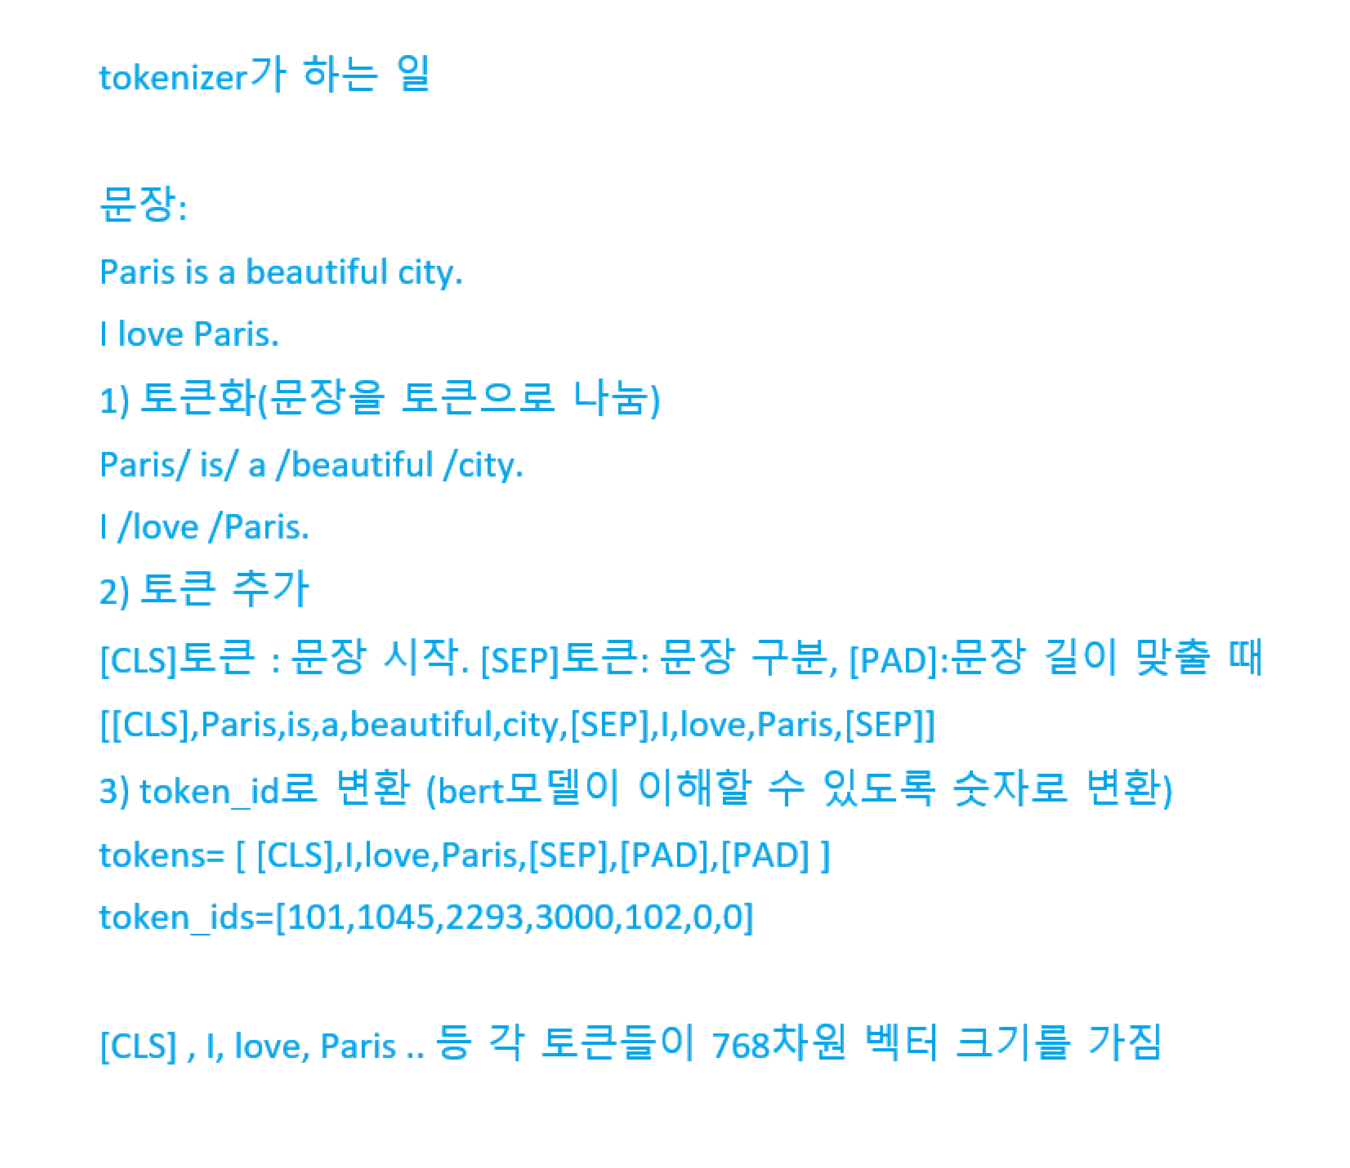

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 경로 설정
img = mpimg.imread(r'C:\Users\itwill\Desktop\token.png')

# 이미지를 화면에 표시
plt.figure(dpi=300)
plt.imshow(img)
plt.axis('off')  
plt.show()

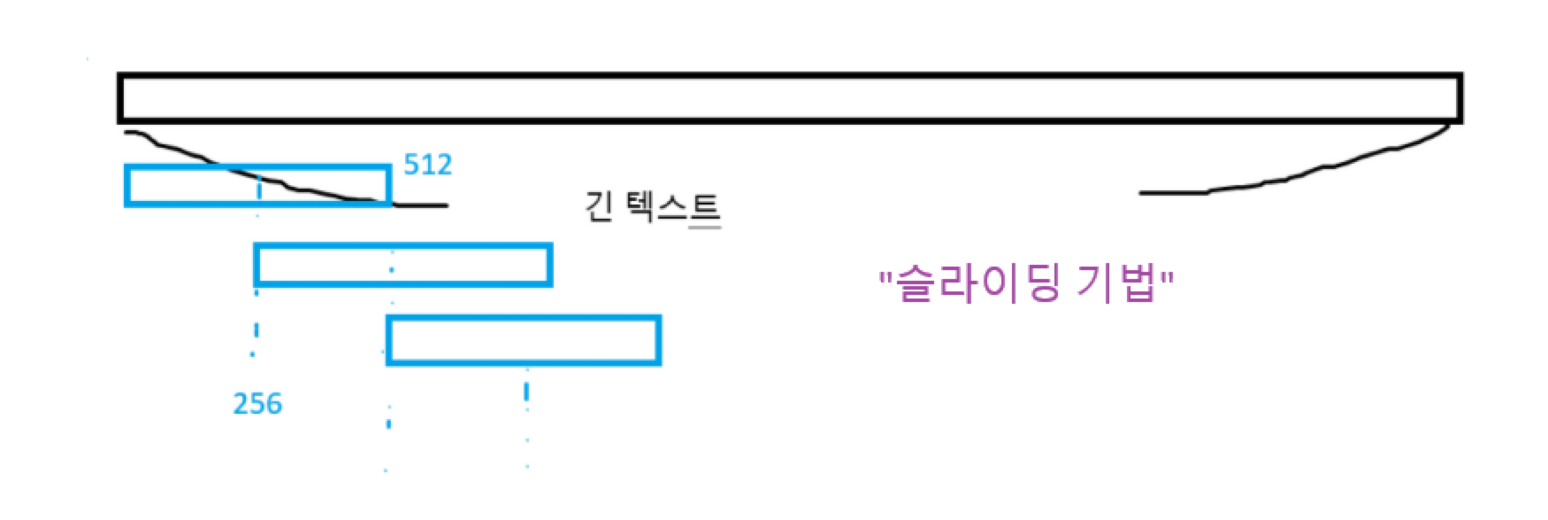

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 경로 설정
img = mpimg.imread(r'C:\Users\itwill\Desktop\slide.png')

# 이미지를 화면에 표시
plt.figure(dpi=300)
plt.imshow(img)
plt.axis('off')  
plt.show()

#모델에 토큰이 최대 512개 밖에 들어가지 않으므로 긴 텍스트를 모델에 넣기 위해서는 
#512개로 나눈 다음 stride 값만큼 밀어서 각 윈도우를 모델에 입력해야함.
#겹치는 부분이 계속 입력되므로 모델이 텍스트의 문맥을 이해할 수 있음
#각 윈도우를 입력으로 여겨서, 최종적으로 각 윈도우에서 [CLS]토큰을 얻게됨

In [61]:
#버전1: [CLS]벡터가 다 모임 --> 정밀한 분석 가능 but 차원이 높음

In [48]:
from kobert_transformers import get_tokenizer
from transformers import BertModel

model = BertModel.from_pretrained("skt/kobert-base-v1")
tokenizer = get_tokenizer()

max_len = 512
stride = 128

results = []  # [CLS]벡터가 모인 곳  #[CLS]토큰: 각 문장에 대한 요약된 값을 나타내는 벡터

for text in data_taka['caption_clean']:
    #텍스트를 토큰화 한 후 token_id를 얻는 과정
    tokens = tokenizer.encode(text, add_special_tokens=True, padding='max_length', max_length=max_len)
    
    #attention mask 생성 -> 1:실제 의미 있는 값이란 것을 표현, 0:빈칸 채우기 인 것을 표현
    attention_mask = [1] * len(tokens)  
    while len(attention_mask) < max_len:  # 최대 길이까지 0으로 채우기
        attention_mask.append(0)
    
    #토큰 자르기(슬라이딩 기법으로) 
    input_ids_list = [] # 여러 개의 슬라이딩 윈도우를 저장할 리스트
    for i in range(0, len(tokens), max_len - stride):
        window = tokens[i:i + max_len]  # [0:128], [129:256], .... # 슬라이딩 윈도우 생성

        # 윈도우가 max_len보다 작을 경우, 패딩을 추가하여 크기 맞춤
        if len(window) < max_len:
            window += [0] * (max_len - len(window))
        input_ids_list.append(window)

    #각 슬라이딩 윈도우에 대해 attention_mask 생성
    for input_ids in input_ids_list:
        attention_mask_window = attention_mask[:len(input_ids)] 
        attention_mask_window = attention_mask_window + [0] * (max_len - len(attention_mask_window)) 

        #token_id랑 1,0을 표시하는 어텐션 마스크를 텐서로 변환
        input_tensor = torch.tensor([input_ids]).to(model.device)
        attention_tensor = torch.tensor([attention_mask_window]).to(model.device)

        #token_id와 attention_mask를 BERT모델에 집어넣음
        with torch.no_grad():  #메모리 아낄려고 with구문 사용
            outputs = model(input_tensor, attention_mask=attention_tensor)
        
        cls_tokens = outputs.last_hidden_state[0][0].cpu().numpy() #최종은닉상태 벡터 -> 12개의 인코더를 거쳐서 나온 최종 값  #[0][0]: 첫 번째 토큰인 [CLS]의 표현 벡터를 제공  
        results.append(cls_tokens) 


In [57]:
print(len(results))  #512보다 작은 값이므로 BERT 모델에 넣을 수 있음.  #print(np.array(results).shape)) #(496,768)

496


In [58]:
from kobert_transformers import get_tokenizer
from transformers import BertModel

model = BertModel.from_pretrained("skt/kobert-base-v1")
tokenizer = get_tokenizer()

max_len = 512
stride = 128

results_t = []  # [CLS]벡터가 모인 곳  #[CLS]토큰: 각 문장에 대한 요약된 값을 나타내는 벡터

for text in data_tongyeong['caption_clean']:
    #텍스트를 토큰화 한 후 token_id를 얻는 과정
    tokens = tokenizer.encode(text, add_special_tokens=True, padding='max_length', max_length=max_len)
    
    #attention mask 생성 -> 1:실제 의미 있는 값이란 것을 표현, 0:빈칸 채우기 인 것을 표현
    attention_mask = [1] * len(tokens)  
    while len(attention_mask) < max_len:  # 최대 길이까지 0으로 채우기
        attention_mask.append(0)
    
    #토큰 자르기(슬라이딩 기법으로) 
    input_ids_list = [] # 여러 개의 슬라이딩 윈도우를 저장할 리스트
    for i in range(0, len(tokens), max_len - stride):
        window = tokens[i:i + max_len]  # [0:128], [129:256], .... # 슬라이딩 윈도우 생성

        # 윈도우가 max_len보다 작을 경우, 패딩을 추가하여 크기 맞춤
        if len(window) < max_len:
            window += [0] * (max_len - len(window))
        input_ids_list.append(window)

    #각 슬라이딩 윈도우에 대해 attention_mask 생성
    for input_ids in input_ids_list:
        attention_mask_window = attention_mask[:len(input_ids)] 
        attention_mask_window = attention_mask_window + [0] * (max_len - len(attention_mask_window)) 

        #token_id랑 1,0을 표시하는 어텐션 마스크를 텐서로 변환
        input_tensor = torch.tensor([input_ids]).to(model.device)
        attention_tensor = torch.tensor([attention_mask_window]).to(model.device)

        #token_id와 attention_mask를 BERT모델에 집어넣음
        with torch.no_grad():  #메모리 아낄려고 with구문 사용
            outputs = model(input_tensor, attention_mask=attention_tensor)
        
        cls_tokens = outputs.last_hidden_state[0][0].cpu().numpy() #최종은닉상태 벡터 -> 12개의 인코더를 거쳐서 나온 최종 값  #[0][0]: 첫 번째 토큰인 [CLS]의 표현 벡터를 제공  
        results_t.append(cls_tokens) 

print(len(results_t))  #print(np.array(results_t).shape))

603


In [63]:
#버전2:[CLS]벡터 평균을 냄 --> 벡터 크기 일정, 메모리 효율 올라감 & 전반적인 의미 파악 가능
###########지금 버전2 result_ta

In [52]:
###함수형 버전
from kobert_transformers import get_tokenizer
from transformers import BertModel

model = BertModel.from_pretrained("skt/kobert-base-v1")
tokenizer = get_tokenizer()

max_len = 512
stride = 128

def get_cls_embeddings(text, model, tokenizer, max_len, stride):
    
    
    tokens = tokenizer.encode(text, add_special_tokens=True, padding='max_length', max_length=max_len)
    
    attention_mask = [1] * len(tokens)
    while len(attention_mask) < max_len:  
        attention_mask.append(0)
    
    input_ids_list = []  
    for i in range(0, len(tokens), max_len - stride):
        window = tokens[i:i + max_len]  
        
        if len(window) < max_len:
            window += [0] * (max_len - len(window))
        input_ids_list.append(window)

    cls_tokens_list = [] 
    
   
    for input_ids in input_ids_list:
        attention_mask_window = attention_mask[:len(input_ids)] + [0] * (max_len - len(input_ids))

        input_tensor = torch.tensor([input_ids]).to(model.device)
        attention_tensor = torch.tensor([attention_mask_window]).to(model.device)

        with torch.no_grad():  
            outputs = model(input_tensor, attention_mask=attention_tensor)

        cls_tokens = outputs.last_hidden_state[0][0].cpu().numpy() 
        cls_tokens_list.append(cls_tokens)
        
    #평균 풀링
    sentence_embedding = np.mean(cls_tokens_list, axis=0)

#함수 사용(다카마쓰)
results_taka = []

for text in data_taka['caption_clean']:
    embedding = get_cls_embeddings(text, model, tokenizer, max_len, stride)
    results_taka.append(embedding)

print(np.array(results_taka).shape) 

#함수 사용(통영)
results_tongyeong = []

for text in data_tongyeong['caption_clean']:
    embedding = get_cls_embeddings(text, model, tokenizer, max_len, stride)
    results_tongyeong.append(embedding)

print(np.array(results_tongyeong).shape) 

(246,)
(298,)


In [81]:
#방법1: 각 문장 [CLS] 벡터를 평균내기
from sklearn.metrics.pairwise import cosine_similarity

# 두 벡터 배열을 numpy array로 변환 (두 리스트의 각 원소가 [CLS] 벡터라고 가정)
embedding_t = np.array(results_t)  # results_t는 [CLS] 벡터로 이루어진 리스트
embedding = np.array(results)      # results도 동일

# 1. 문서의 평균 벡터 계산
avg_embedding_t = np.mean(embedding_t, axis=0)  # 다카마쓰 문서의 평균 벡터
avg_embedding = np.mean(embedding, axis=0)      # 통영 문서의 평균 벡터

# 2. 두 평균 벡터 간의 코사인 유사도 계산
similarity = cosine_similarity([avg_embedding_t], [avg_embedding])

# 유사도 출력
print(f"다카마쓰와 통영 문서 간의 유사도: {similarity[0][0]}")


다카마쓰와 통영 문서 간의 유사도: 0.9929025173187256


In [ ]:
#방법2: 각 문장별 [CLS] 벡터 간의 유사도를 평균내기
from sklearn.metrics.pairwise import cosine_similarity

# 다카마쓰 문서의 [CLS] 벡터들 (여러 문장)
embedding_t = np.array(results)

# 통영 문서의 [CLS] 벡터들 (여러 문장)
embedding = np.array(results_t)

# 문장 간의 유사도를 계산
similarities = []

# 각 문장별로 [CLS] 벡터 간의 유사도를 계산
for vec_t in embedding_t:
    for vec in embedding:
        similarity = cosine_similarity([vec_t], [vec])
        similarities.append(similarity[0][0])

# 유사도의 평균 계산
avg_similarity = np.mean(similarities)

# 유사도 출력
print(f"다카마쓰와 통영 문서 간의 평균 유사도: {avg_similarity}")
